In [2]:
import os
os.chdir("..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

In [4]:
import sys
import random

In [5]:
import warnings
# block tensorflow~numpy warnings
warnings.filterwarnings('ignore')

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные маски для картинок из `valid` в формате `pred_valid_template.csv`;
- html страницу с предсказанием модели для всех картинок из `test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез и т.п.

Примеры приведены ниже.

---

# Environment

In [32]:
BATCH_SIZE = 10 
# memory issues on 8 gig container
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3

TRAIN_PATH = 'data/train'
TRAIN_MASK_PATH = 'data/train_mask'

VALIDATE_PATH = 'data/valid'
VALIDATE_MASK_PATH = 'data/valid_mask'

TEST_PATH = 'data/test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 83

images = os.listdir(TRAIN_PATH)
val_images = os.listdir(VALIDATE_PATH)
test_images = os.listdir(TEST_PATH)


In [96]:
def get_xy(images, img_path, img_mask_path=None):
    SIZE = len(images)
    
    X_= np.zeros((SIZE , IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_ = np.zeros((SIZE , IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    for img_file_index in range(SIZE):

        ind = images[img_file_index].split(".")[0]
        
        img = imread(f"{img_path}/{ind}.jpg")[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        
        X_[img_file_index] = np.array(img)
        if(img_mask_path):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            
            mask_ = imread(f"{img_mask_path}/{ind}.png")
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        
            Y_[img_file_index] = np.maximum(mask, mask_)
        
    return (X_, Y_)



# Данные

Посмотрим на данные:

In [97]:
X_train, Y_train = get_xy(images, TRAIN_PATH, TRAIN_MASK_PATH)
X_validate, Y_validate = get_xy(val_images, VALIDATE_PATH, VALIDATE_MASK_PATH)
X_test, Y_test_placeholder = get_xy(test_images, TEST_PATH)

In [98]:
random_index = np.random.choice(X_train.shape[0])

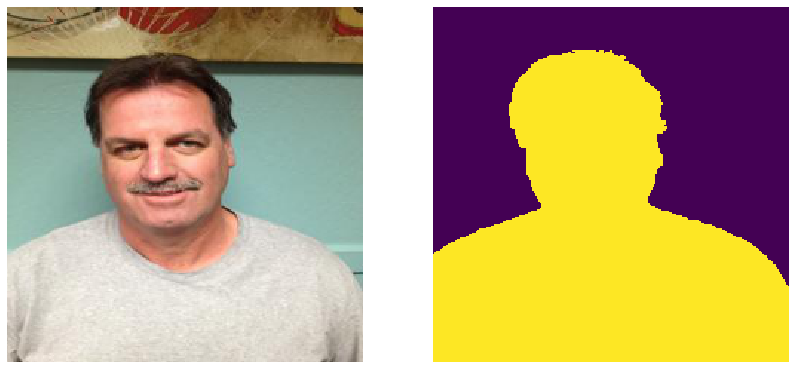

In [99]:
show_img_with_mask(X_train[random_index], Y_train[random_index][:,:,0])

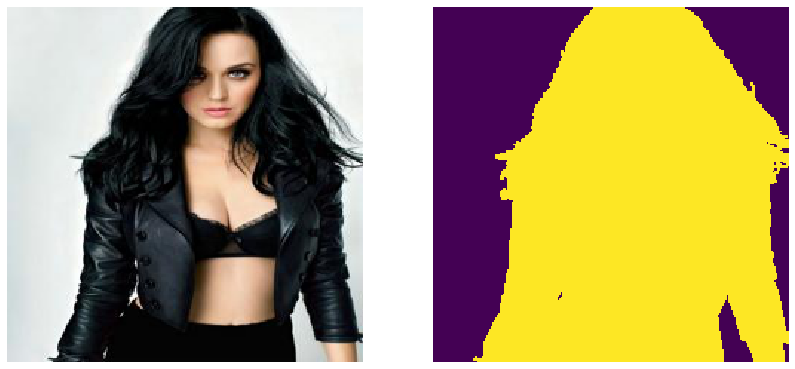

In [101]:
random_index = np.random.choice(X_validate.shape[0])
show_img_with_mask(X_validate[random_index], Y_validate[random_index][:,:,0])

# Preprocessing

## data augmentation

shearing of images to overcome overfitting

In [102]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')


In [103]:
# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

In [104]:
x=image_datagen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_validate, augment=True, seed=seed)
mask_datagen_val.fit(Y_validate, augment=True, seed=seed)

x_val=image_datagen_val.flow(X_validate,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_validate,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

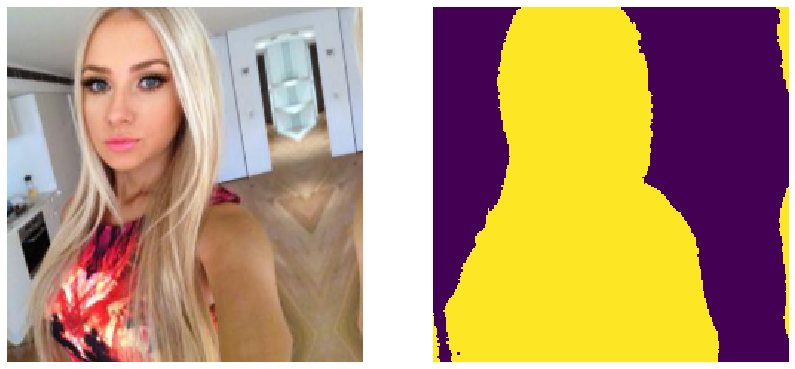

In [105]:
show_img_with_mask(x.next()[0].astype(np.uint8), np.squeeze(y.next()[0].astype(np.uint8)))

In [106]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

# additional metric 

<a href='https://en.wikipedia.org/wiki/Jaccard_index'>Intersection over Union</a>

In [107]:
def mean_iou(y_true, y_pred):
    print(y_true)
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Neural Network ~ U-Net 

In [108]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])

c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)



In [109]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Tensor("conv2d_124_target:0", shape=(?, ?, ?, ?), dtype=float32)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 240, 240, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 240, 240, 16) 448         lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_51 (Dropout)            (None, 240, 240, 16) 0           conv2d_106[0][0]                 
___________________________

In [110]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-segmentation-1.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=5, callbacks=[earlystopper, checkpointer])

Epoch 1/5
250/250 [==============================] - 1436s 6s/step - loss: 0.5929 - mean_iou: 0.3420 - val_loss: 0.4921 - val_mean_iou: 0.3937

Epoch 00001: val_loss improved from inf to 0.49215, saving model to model-segmentation-1.h5
Epoch 2/5
250/250 [==============================] - 1405s 6s/step - loss: 0.5080 - mean_iou: 0.4189 - val_loss: 0.4970 - val_mean_iou: 0.4378

Epoch 00002: val_loss did not improve from 0.49215
Epoch 3/5
250/250 [==============================] - 1269s 5s/step - loss: 0.4871 - mean_iou: 0.4518 - val_loss: 0.4336 - val_mean_iou: 0.4619

Epoch 00003: val_loss improved from 0.49215 to 0.43362, saving model to model-segmentation-1.h5
Epoch 4/5
250/250 [==============================] - 1298s 5s/step - loss: 0.4579 - mean_iou: 0.4714 - val_loss: 0.3738 - val_mean_iou: 0.4801

Epoch 00004: val_loss improved from 0.43362 to 0.37383, saving model to model-segmentation-1.h5
Epoch 5/5
250/250 [==============================] - 1365s 5s/step - loss: 0.4450 - mean_

In [ ]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-segmentation-2.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=10, callbacks=[earlystopper, checkpointer])

Epoch 1/10
250/250 [==============================] - 1364s 5s/step - loss: 0.4323 - mean_iou: 0.4993 - val_loss: 0.3428 - val_mean_iou: 0.5056

Epoch 00001: val_loss improved from inf to 0.34277, saving model to model-segmentation-2.h5
Epoch 2/10
103/250 [===========>..................] - ETA: 12:18 - loss: 0.4100 - mean_iou: 0.5084

In [75]:
prediction = model.predict(X_test[2][None,:,:,:])[0]

In [76]:
prediction.shape

(240, 240, 1)

In [77]:
data_img = (prediction.squeeze()*255).astype(np.uint8)

print("size: %s, type: %s"%(data_img.shape, data_img.dtype))


size: (240, 240), type: uint8


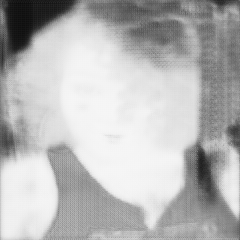

In [78]:
img = Image.fromarray(data_img)
#mg = img.resize([img.width*2,img.height*2])
img